In [1]:
import json
import pandas as pd
import re
from googletrans import Translator
from google_trans_new import google_translator  
import time
from time import sleep
from random import uniform
import datetime
from datetime import date, timezone
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
import spacy
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import numpy as np

# 1. Image Text Analysis

## 1.1 Prepare Data

In [2]:
# Defining a function to remove accented characters in English text
def remove_accents(sentence):
    return ", ".join(simple_preprocess(str(sentence), deacc=True, max_len=100))

# Detecting non-English text using regex
def detect_lang(text):
    pat = re.compile("[^\x00-\x7F]") # matches non-English characters
    if pat.search(text):
        return 0
    else:
        return 1

In [3]:
## text in image
with open('../image_text.json') as f:
  data_dict = json.load(f)

df = pd.DataFrame.from_dict(data_dict)
df = df.T
df = df.reset_index()
clean_df = df

clean_df["is_english"] = df["text"].map(detect_lang)
unique_df = clean_df.drop_duplicates(subset = ["text"])
english = unique_df[(unique_df['is_english'] ==1)]
english["english_text"] =english["text"]

<ipython-input-3-75c7cc6f8833>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english["english_text"] =english["text"]


In [4]:
non_english = pd.read_csv('non_english_jun2021.csv')

In [5]:
all_english = pd.concat([english, non_english])

<ipython-input-5-c27270e107fc>:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  all_english = pd.concat([english, non_english])


## 1.2. Tokenize Data

In [7]:
#all_english.iloc[1]['english_text']

In [92]:
# from nltk.tokenize import word_tokenize
# all_text = all_english["english_text"].str.cat(sep='\n')
# tokenized_word= word_tokenize(all_text)
# print(tokenized_word)

In [133]:
# from nltk.probability import FreqDist
# fdist = FreqDist(tokenized_word)
# print(fdist)

In [134]:
# # Frequency Distribution Plot
# import matplotlib.pyplot as plt
# fdist.plot(30,cumulative=False)
# plt.show()

In [94]:
# Creating stop words list
stop_words = stopwords.words("english")

# Adding domain words 
stop_words.extend(["will","yes","#",".","_","%","|","r","sr"])

In [146]:
# nlp = spacy.load('en_core_web_sm')
# doc = nlp("Little update Any blood group will do as we would be")
# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#         token.shape_, token.is_alpha, token.is_stop)

In [9]:
nlp = spacy.load('en_core_web_sm')
allowed_posttags=["NOUN", "PROPN", "VERB", "ADJ", "ADV"]
lemmatized_tokens = []
for text in all_english["english_text"]:
    #print(text)
    doc = nlp(text)
    for token in doc:
        if(token.pos_ in allowed_posttags):
            lemmatized_tokens.append(token.lemma_)
        #print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        #    token.shape_, token.is_alpha, token.is_stop)

In [95]:
lemmatized_tokens_lower = map(str.lower, lemmatized_tokens)

In [96]:
lemmatized_tokens_stopped = [token for token in lemmatized_tokens_lower if token not in stop_words]

In [63]:
#lemmatized_tokens_stopped = lemmatized_tokens_stopped[lemmatized_tokens_stopped['english_text'].apply(lambda x: len(str(x)) >3)]

TypeError: list indices must be integers or slices, not str

In [97]:
from nltk.probability import FreqDist
fdist = FreqDist(lemmatized_tokens_stopped)
print(fdist)

<FreqDist with 25122 samples and 133901 outcomes>


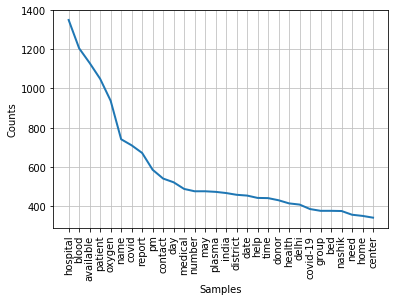

In [98]:
# Frequency Distribution Plot
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [102]:
image_word_freq = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])
image_total_words = sum(image_word_freq['frequency']) #len(WA_word_freq)
image_word_freq['img_proportion'] = image_word_freq['frequency']/image_total_words

In [103]:
image_word_freq

,word,frequency,img_proportion
0,little,18,0.000134
1,update,53,0.000396
2,blood,1205,0.008999
3,group,374,0.002793
4,would,66,0.000493
...,...,...,...
25117,paeumothena,1,0.000007
25118,sav,1,0.000007
25119,tabel,1,0.000007
25120,govnd,1,0.000007


# 2. Analysis of WhatsApp Conversations

## 2.1 Prepare Data

In [21]:
WA_text = pd.read_csv('whatsapp_text_all_english_2021.csv')
WA_text = WA_text[WA_text['Has Media'] == False]

excluded_groups = ['1d80c681c6bd089ed87f5621b2b5a5c1b863e978cf3bc1bceddfe3634e9713c5',
                  '3b7ab2f5937776fc15436c4aa8c7ce4a5794d04dcc7abd634a26b23a43baed90',
                  '53256805e4ca4bc13d0f6b0def75afa1ea2f85be25015d123b20faab3506503a',
                  '334f40dd68492c94847832d40b67b59f675dc3da577ed548390c3511f6459f67',
                  '6ddab15f6695c440c164230b4d1aacff195423fc3759191bf4179c990a617c45',
                  '88f77040e70941006eff31f4297352cf7b1453e3a2b15a9c7c25f590a2a90354']
WA_text = WA_text[~WA_text['Group ID'].isin(excluded_groups)]

In [22]:
WA_text.shape

(7542, 14)

## 2.2 Tokenize Data

In [71]:
nlp = spacy.load('en_core_web_sm')
allowed_posttags=["NOUN", "PROPN", "VERB", "ADJ", "ADV"]
WA_lemmatized_tokens = []
for text in WA_text["english_Content"]:
    #print(text)
    doc = nlp(text)
    for token in doc:
        if(token.pos_ in allowed_posttags):
            WA_lemmatized_tokens.append(token.lemma_)
        #print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        #    token.shape_, token.is_alpha, token.is_stop)

In [72]:
WA_lemmatized_tokens_lower = map(str.lower, WA_lemmatized_tokens)
WA_lemmatized_tokens_stopped = [token for token in WA_lemmatized_tokens_lower if token not in stop_words]

In [73]:
from nltk.probability import FreqDist
WA_fdist = FreqDist(WA_lemmatized_tokens_stopped)
print(WA_fdist)

<FreqDist with 12427 samples and 80260 outcomes>


In [74]:
WA_word_freq=pd.DataFrame(WA_fdist.items(), columns=['word', 'frequency'])

In [140]:
# # Frequency Distribution Plot
# import matplotlib.pyplot as plt
# WA_fdist.plot(30,cumulative=False)
# plt.show()

In [75]:
WA_total_words = sum(WA_word_freq['frequency']) #len(WA_word_freq)

In [76]:
WA_word_freq['WA_proportion'] = WA_word_freq['frequency']/WA_total_words

In [77]:
WA_word_freq.head(2)

,word,frequency,WA_proportion
0,https://twitter.com/thejibrailkhan/status/1393...,1,0.000012
1,read,42,0.000523


# 3. Compare Image and Text Data

In [104]:
result = pd.merge(WA_word_freq, image_word_freq, how="outer", on=["word"])

In [120]:
# result_inner = pd.merge(WA_word_freq, image_word_freq, how="outer", on=["word"])
# result['WA_proportion'] = result['frequency_x']/76862
# result['img_proportion'] = result['frequency_y']/102893
# print(sum(result['frequency_y']))
# print(sum(WA_word_freq['frequency']))

In [105]:
result.head(2)

,word,frequency_x,WA_proportion,frequency_y,img_proportion
0,https://twitter.com/thejibrailkhan/status/1393...,1.0,0.000012,NaN,NaN
1,read,42.0,0.000523,63.0,0.00047


In [106]:
result['prop_diff'] = abs(result["WA_proportion"] - result["img_proportion"])

In [107]:
temp = result[["WA_proportion","img_proportion"]]
temp.corr(method='pearson')#, min_periods=1)

,WA_proportion,img_proportion
WA_proportion,1.000000,0.831193
img_proportion,0.831193,1.000000


In [226]:
result_clean = result[result.WA_proportion.notnull()]
result_clean = result_clean[result_clean.img_proportion.notnull()]


In [227]:
result_clean =result_clean[(result_clean['WA_proportion'] > 0.0004) & (result_clean['img_proportion'] > 0.0004)]

In [228]:
result_clean.shape

(242, 6)

In [171]:
result_clean.to_csv('check_Words.csv')

# 4. Plot Graphs


In [231]:
import plotly.express as px
import plotly.graph_objects as go

fig1 = px.scatter(result_clean, x="WA_proportion", y="img_proportion", text="word", size_max=60, 
                 trendline="ols",
                 log_x=True, log_y=True)


fig1.update_traces(textposition='top center')

fig1.update_layout(
    #height=800,
    #plot_bgcolor="white",
    title_text='Comparison of Words Found in Text Messages and Images'
   
)

fig1.update_yaxes(range=list([-3.3880341096413864, -1.6965818195541233]))
fig1.update_xaxes(range=list([-3.3880341096413864, -1.6965818195541233]))


ax_arr = np.arange(0, 1) #list(range(-3.3880341096413864, -1.6965818195541233))
fig2 = px.line(x=ax_arr,y=ax_arr,log_x=True,log_y=True,) #, color=rgb(140, 140, 140))      
#fig2.update_layout(plot_bgcolor="white")
               


fig = go.Figure(data=fig1.data + fig2.data)

fig.update_xaxes(type="log", range=list([-3.3880341096413864, -1.6965818195541233])) 
fig.update_yaxes(type="log", range=list([-3.3880341096413864, -1.6965818195541233]))

fig.update_layout(
    #plot_bgcolor="white",
    autosize=False,
    width=900,
    height=900
)

fig.show()

In [236]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=result_clean["WA_proportion"], y=result_clean["img_proportion"],
              mode="markers+text",text=result_clean["word"],
              textposition='bottom left',
              marker=dict(
                    color='#514E80',
                    size=5,
                    opacity=0.5,)
              )
)

ax_arr = np.arange(0, 1.0375284158)
fig.add_trace(go.Scatter(
        x=ax_arr,
        y=ax_arr,
        mode="lines",
        line=dict(color="#c2c2d6", 
                 dash='dot')
        )
)


fig.update_xaxes(type="log", range=[-3.3880341096413864, -1.6965818195541233],
                 showgrid=True,linecolor='black',gridcolor='#EDC9C4')
fig.update_yaxes(type="log", range=[-3.3880341096413864, -1.6965818195541233],
                 showgrid=True,linecolor='black',gridcolor='#EDC9C4')


fig.update_layout(
    plot_bgcolor="white",
    autosize=False,
    width=900,
    height=900
)

fig.show()

In [174]:
fig = px.scatter(result_clean, x="WA_proportion", y="img_proportion", text="word", size_max=60, 
                 trendline="ols",
                 log_x=True, log_y=True)


fig.update_traces(textposition='top center')

fig.update_layout(
    #height=800,
    #plot_bgcolor="white",
    title_text='Comparison of Words Found in Text Messages and Images'
   
)

full_fig = fig.full_figure_for_development()
print(full_fig.layout.xaxis.range)
print(full_fig.layout.yaxis.range)

(-3.3880341096413864, -1.6965818195541233)
(-3.390338188358278, -1.9068208812938081)


0.614482103115227
0.6144819326148592 4.099461467289302e-05


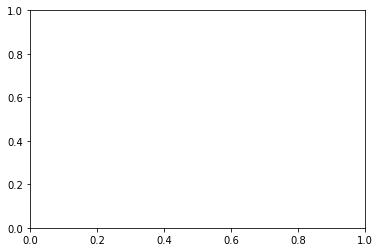

In [89]:
x = result_clean["WA_proportion"]
y = result_clean["img_proportion"]


# sdx = np.std(x)
# sdy = np.std(y)

# beta = (sdy/sdx)*0.820648
# print(beta)


## Plot Abline
axes = plt.gca()
# Find the slope and intercept of the best fit line
slope, intercept = np.polyfit(x, y, 1)

print(slope,intercept)

0.6144819326148592 4.099461467289302e-05


Text(0, 0.5, 'Proportion of word in Images')

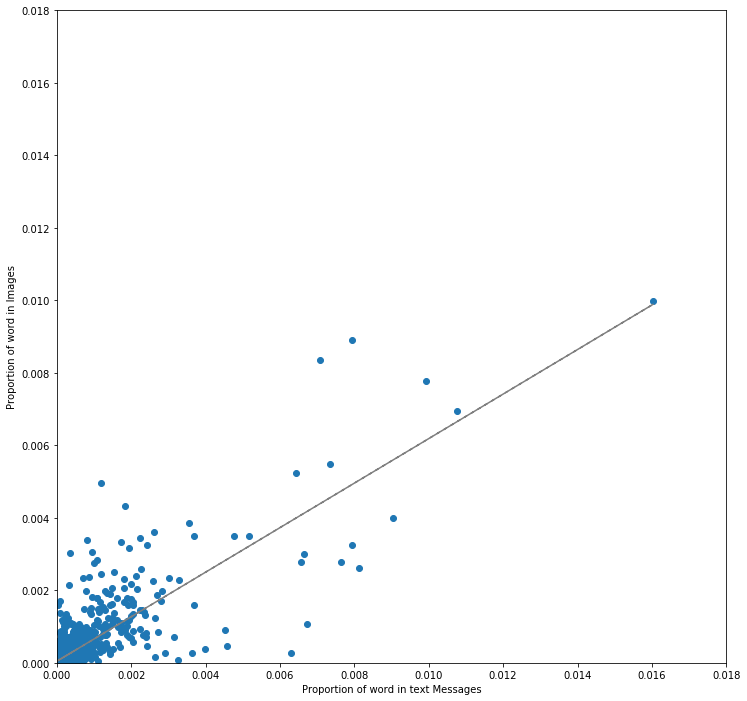

In [57]:
x = result_clean["WA_proportion"]
y = result_clean["img_proportion"]
fig = plt.figure(figsize=(12, 12))

# Plot the best fit line over the actual values
plt.scatter(x="WA_proportion", y="img_proportion", data=result_clean)
plt.xlim([0, 0.018])
plt.ylim(0, 0.018)


## Plot Abline
axes = plt.gca()
# Find the slope and intercept of the best fit line
slope, intercept = np.polyfit(x, y, 1)
print(slope,intercept)

# Create a list of values in the best fit line
abline_values = [slope * i + intercept for i in x]

plt.plot(x, abline_values, '--', color="gray")

plt.xlabel("Proportion of word in text Messages")
plt.ylabel("Proportion of word in Images")


[(0, 0.018)]

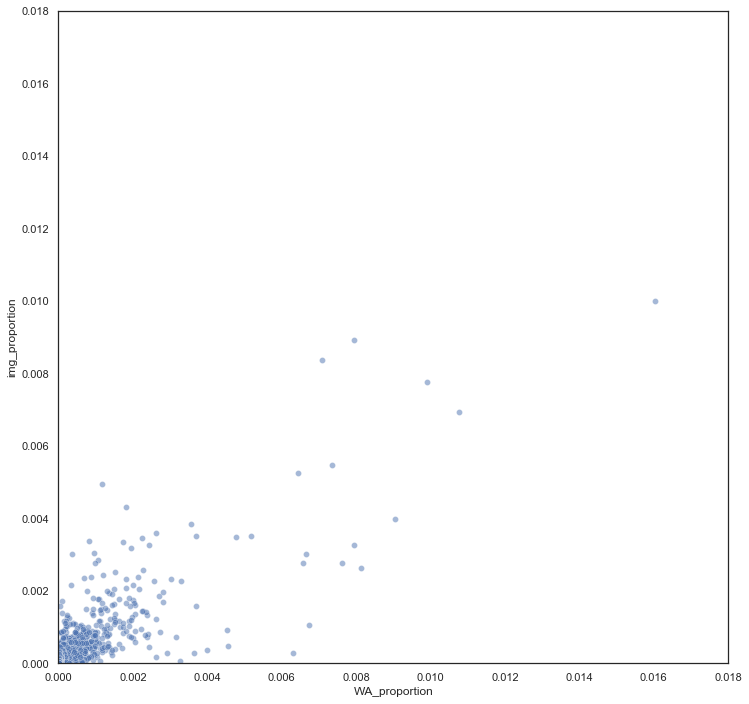

In [244]:
import seaborn as sns
fig = plt.figure(figsize=(12, 12))

sns.set_theme(style="white")

cmap =  sns.cubehelix_palette(as_cmap=True)

splt = sns.scatterplot(x="WA_proportion", y="img_proportion", data=result_clean, 
                #hue='prop_diff', 
                sizes=(40, 400), alpha=.5, palette="muted",
                cmap=cmap)

splt.set(ylim=(0, 0.018))
splt.set(xlim=(0, 0.018))